In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline
import argparse
import os
import numpy as np
import torch
import torch.optim
from torch import nn
from torchvision import transforms
from model import UNet
from metrics import Metrics
import torch.functional as F
from PIL import Image
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from torch.utils.data import Dataset, DataLoader

In [2]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda:0


In [3]:
class DIP:
    def __init__(
        self, 
        low_res: torch.Tensor, 
        high_res: torch.Tensor,
        input: torch.Tensor,
        reg_noise_std: float, 
        num_iterations: int,
        criterion: nn.MSELoss,
        optimizer: torch.optim.Optimizer,
        device: torch.device,
        metrics: Metrics,
        model: nn.Module,
        summary_writer: SummaryWriter,
    ):
        self.low_res = low_res
        self.low_res_size = self.low_res.shape[-1]
        self.high_res = high_res.unsqueeze(0)
        self.input = input
        self.reg_noise_std = 0.05
        self.num_iterations = num_iterations
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.metrics = metrics
        self.model = model
        self.summary_writer = summary_writer
        self.step = 0
        self.history = []
    
    def closure(self, input_saved: torch.Tensor, noise: torch.Tensor):        
        if self.reg_noise_std > 0:
            self.input = input_saved + (noise.normal_() * self.reg_noise_std)
    
        self.input = self.input.to(self.device)
        self.low_res = self.low_res.to(self.device)
        
        output_hr = self.model(self.input)
        output_lr = downsample(output_hr, (self.low_res_size, self.low_res_size))
        
        loss = self.criterion(output_lr, self.low_res)
        loss.backward()

        if self.step <= 100 and self.step % 10 == 0 or \
           self.step % 100 == 0 or \
           self.step == self.num_iterations-1:
        
            mse, psnr, ssim, lpips = self.evaluate(output_hr)     
            print(f"{self.step} Loss: {loss} MSE: {mse} PSNR: {psnr} SSIM: {ssim} LPIPS: {lpips}")
            self.log(loss, mse, psnr, ssim, lpips, self.step)
            if self.step == self.num_iterations-1:
                self.mse = mse
                self.psnr = psnr
                self.ssim = ssim
                self.lpips = lpips
            
            output_hr_numpy = output_hr.squeeze(0).permute(1,2,0).cpu().detach().numpy()
            plt.imshow(output_hr_numpy)
            plt.show()
            self.history.append(output_hr_numpy)
        self.step += 1

    def train(self, input: torch.Tensor) -> (float, float, float, float) :
        input_saved = input.detach().clone()
        noise = input.detach().clone()
        
        for i in range(self.num_iterations):
            self.optimizer.zero_grad()
            self.closure(input_saved, noise)
            self.optimizer.step()

        return self.mse, self.psnr, self.ssim, self.lpips

    def evaluate(self, prediction):
        prediction = prediction.to(self.device)
        self.high_res = self.high_res.to(self.device)
        mse = self.metrics.calculate_mse(prediction, self.high_res)
        psnr = self.metrics.calculate_psnr(prediction, self.high_res)
        ssim = self.metrics.calculate_ssim(prediction, self.high_res)
        lpips = self.metrics.calculate_lpips(prediction, self.high_res)
        return mse, psnr, ssim, lpips

    def log(self, loss, mse, psnr, ssim, lpips, step):
        self.summary_writer.add_scalars(
            "loss",
            {"train": float(loss)},
            self.step
        )
        self.summary_writer.add_scalars(
            "mse",
            {"train": float(mse)},
            self.step
        )
        self.summary_writer.add_scalars(
            "psnr",
            {"train": float(psnr)},     
            self.step
        )
        self.summary_writer.add_scalars(
            "ssim",
            {"train": float(ssim)},
            self.step
        )
        self.summary_writer.add_scalars(
            "lpips",
            {"train": float(lpips)},
            self.step
        )

    def get_history(self) -> np.ndarray:
        return self.history

In [4]:
def downsample(image: torch.Tensor, size: (int, int)):
    transform = transforms.Resize(size, interpolation=transforms.InterpolationMode.BICUBIC)
    return transform(image)

In [5]:
def display_tensor(tensor: torch.Tensor):
    tensor = tensor.permute(1,2,0).detach().cpu().numpy()
    tensor = (tensor - np.min(tensor)) / (np.max(tensor) - np.min(tensor))
    plt.imshow(tensor)

In [6]:
def min_max_norm(tensor: torch.Tensor) -> torch.Tensor:
    tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())
    return tensor

In [8]:
def main(low_res: torch.Tensor, high_res: torch.Tensor, id: int, num_iterations: int, reg_noise_std: float, histories, log_id: str):
    input = torch.randn_like(high_res).unsqueeze(0)
    input *= 0.1
    
    model = UNet(input_channels=3, output_channels=3)
    model = model.to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    metrics = Metrics()
    
    log_dir = "./logs"
    os.makedirs(log_dir, exist_ok=True)
    log_path = f"{log_dir}/run_{log_id}/{id}" 
    print(f"Writing logs to {log_path}")
    summary_writer = SummaryWriter(
        str(log_path),
        flush_secs=5,
    )

    dip = DIP(
        low_res = low_res, 
        high_res = high_res,
        input = input,
        reg_noise_std = reg_noise_std, 
        num_iterations = num_iterations,
        criterion = criterion,
        optimizer = optimizer,
        device = DEVICE,
        metrics = metrics,
        model = model,
        summary_writer = summary_writer,      
    )

    histories[id] = dip.get_history()

    return dip.train(input)

In [9]:
def plot_history(history: [np.ndarray]):
    m, n = 4, 5
    fig, axes = plt.subplots(m, n)
    for j in range(m):
        for i in range(n):
            if m == 1:
                axes[i].imshow(history[i])
                axes[i].axis("off")
            else:
                axes[j][i].imshow(history[j*n + i])
                axes[j][i].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    

In [10]:
NOISE_LEVEL = 0
DOWN_FACTOR = 8
LOOPS = 1
lr_input_dir = f"./input/noise_{NOISE_LEVEL}_down_{DOWN_FACTOR}"
hr_input_dir = f"./input/original_high"

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/opt/anaconda/3-2024/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda/3-2024/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/lj21689/.local/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth
Writing logs to ./logs/run_2024-11-28_16-51-49/0


/home/lj21689/.local/lib/python3.12/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_location=

0 Loss: 0.07469415664672852 MSE: 0.12868933379650116 PSNR: 8.904574394226074 SSIM: 0.02336786687374115 LPIPS: 1.1924349069595337


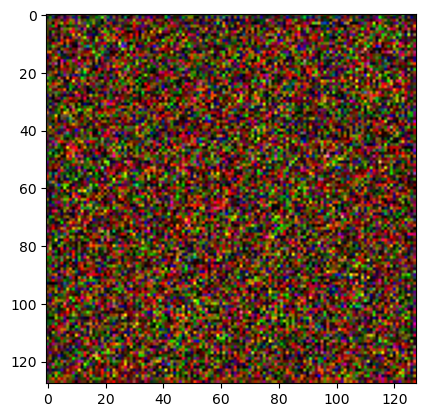

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10 Loss: 0.06445573270320892 MSE: 0.16583797335624695 PSNR: 7.803159713745117 SSIM: 0.11084546893835068 LPIPS: 0.8100817799568176


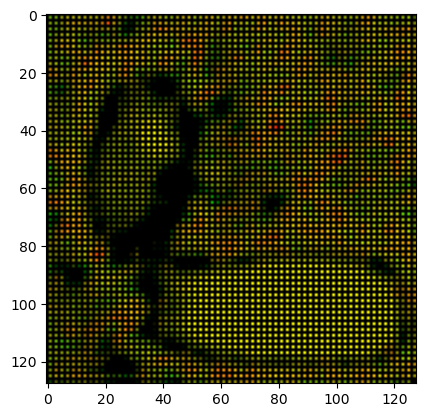

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


20 Loss: 0.030344977974891663 MSE: 0.46995413303375244 PSNR: 3.279444932937622 SSIM: 0.10900740325450897 LPIPS: 0.8453847765922546


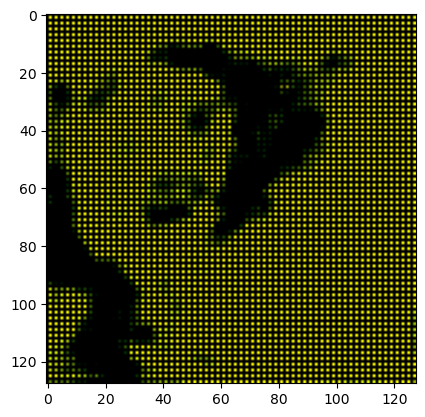

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


30 Loss: 0.01361238956451416 MSE: 0.4913744330406189 PSNR: 3.0858752727508545 SSIM: 0.11965467035770416 LPIPS: 0.7819247245788574


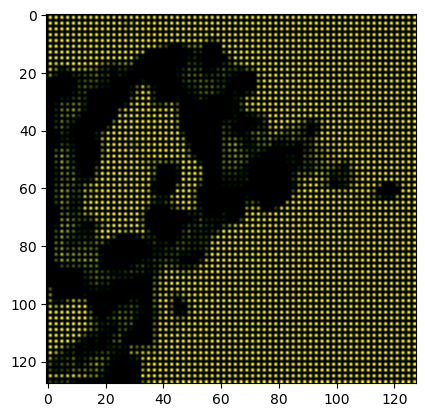

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


40 Loss: 0.005838822573423386 MSE: 0.3973996043205261 PSNR: 4.007726192474365 SSIM: 0.1298193335533142 LPIPS: 0.7150334119796753


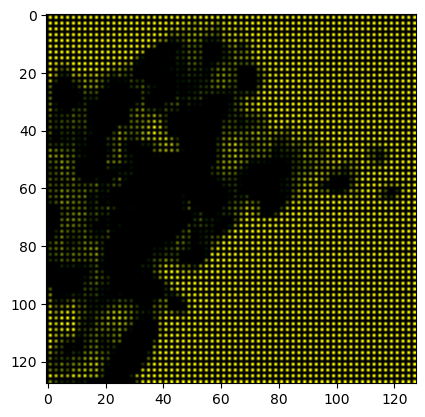

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


50 Loss: 0.003499477868899703 MSE: 0.4876892566680908 PSNR: 3.1185686588287354 SSIM: 0.12455147504806519 LPIPS: 0.7106785178184509


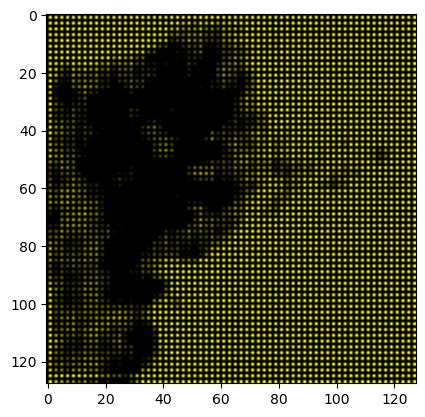

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


60 Loss: 0.002455894835293293 MSE: 0.436711847782135 PSNR: 3.598050117492676 SSIM: 0.12658312916755676 LPIPS: 0.7037299275398254


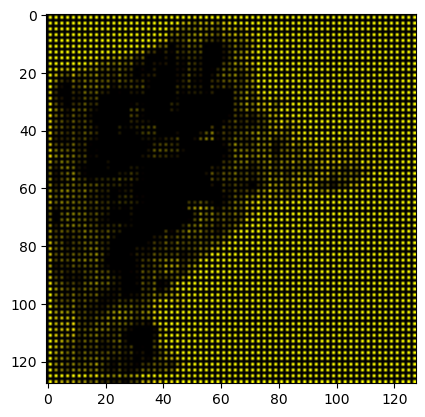

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


70 Loss: 0.0022456063888967037 MSE: 0.46116766333580017 PSNR: 3.3614120483398438 SSIM: 0.12959256768226624 LPIPS: 0.7036725282669067


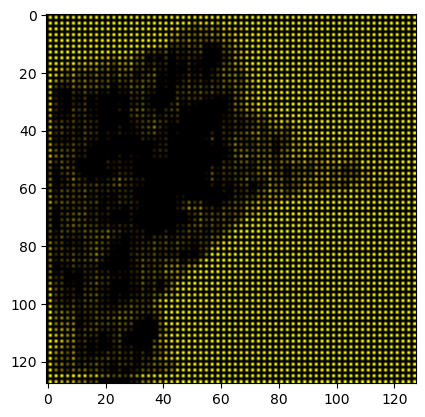

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


80 Loss: 0.001815721159800887 MSE: 0.45283371210098267 PSNR: 3.4406118392944336 SSIM: 0.1292189061641693 LPIPS: 0.6875655651092529


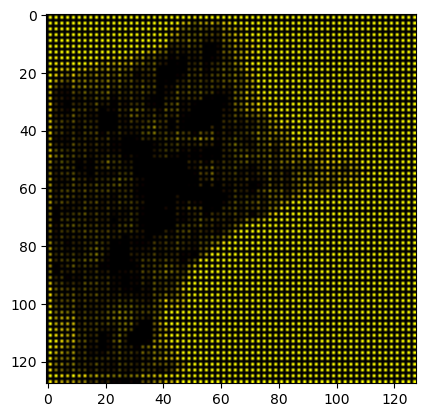

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


90 Loss: 0.0017774521838873625 MSE: 0.4557436406612396 PSNR: 3.4127941131591797 SSIM: 0.12249013781547546 LPIPS: 0.7002022862434387


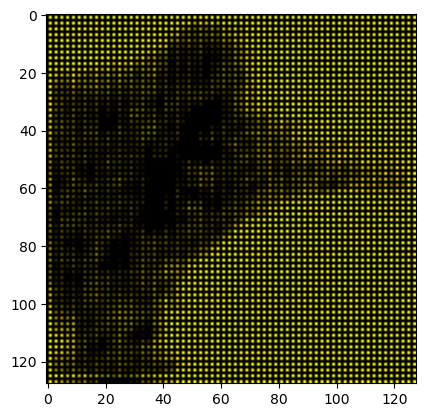

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


100 Loss: 0.0014942766865715384 MSE: 0.45345544815063477 PSNR: 3.4346542358398438 SSIM: 0.12145106494426727 LPIPS: 0.6944120526313782


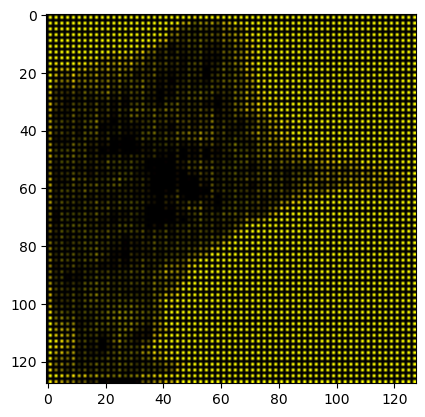

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


200 Loss: 0.001214971300214529 MSE: 0.455282986164093 PSNR: 3.4171855449676514 SSIM: 0.12547564506530762 LPIPS: 0.674508273601532


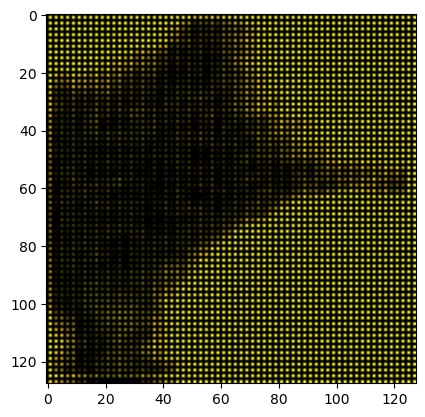

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


300 Loss: 0.0010784706100821495 MSE: 0.4533848166465759 PSNR: 3.435330867767334 SSIM: 0.12527644634246826 LPIPS: 0.6769627332687378


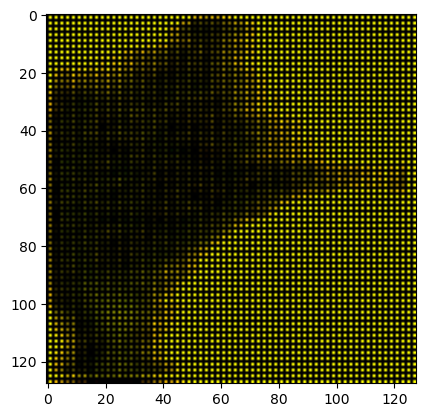

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


400 Loss: 0.0010689469054341316 MSE: 0.45342791080474854 PSNR: 3.434917688369751 SSIM: 0.12770849466323853 LPIPS: 0.6753427982330322


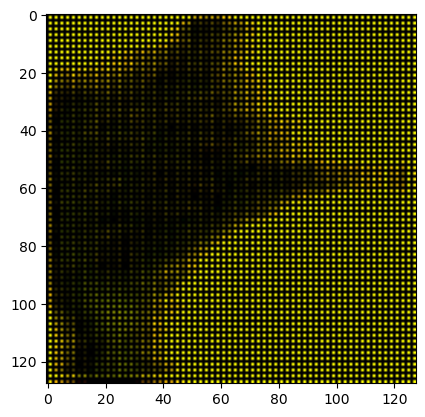

KeyboardInterrupt: 

In [11]:
image_indices = [(0,1), (1,0), (1,3), (3,7)]
overall_histories = {}
time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
total_mse = 0
total_psnr = 0
total_ssim = 0
total_lpips = 0
for j in range(LOOPS):
    overall_histories[j] = {}
    histories = overall_histories[j]
    for i, indices in enumerate(image_indices):
        low_res = Image.open(f"{lr_input_dir}/original_low-{indices[0]}-{indices[1]}.jpg")
        high_res = Image.open(f"{hr_input_dir}/original_high-{indices[0]}-{indices[1]}.jpg")
        
        low_res = transforms.ToTensor()(low_res)
        low_res = min_max_norm(low_res)
        assert (low_res.shape[-1] % 8 == 0)
        down_scale_size = low_res.shape[-1] // 8
        low_res = downsample(low_res, (down_scale_size, down_scale_size))
    
        high_res = transforms.ToTensor()(high_res)
        high_res = min_max_norm(high_res)
        
        mse, psnr, ssim, lpips = main(
            low_res=low_res, 
            high_res=high_res, 
            id=i,
            num_iterations = 1000,
            reg_noise_std = 0.05,
            histories = histories,
            log_id = time, 
        )
        total_mse += mse
        total_psnr += psnr
        total_ssim += ssim
        total_lpips += lpips
avg_mse = total_mse / len(image_indices) / LOOPS
avg_psnr = total_psnr / len(image_indices) / LOOPS
avg_ssim = total_psnr / len(image_indices) / LOOPS
avg_lpips = total_lpips / len(image_indices) / LOOPS
print(f"Test Evaluaton: Avg MSE: {avg_mse} Avg PSNR {avg_psnr} Avg SSIM {avg_ssim} Avg LPIPS {avg_lpips}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

IndexError: list index out of range

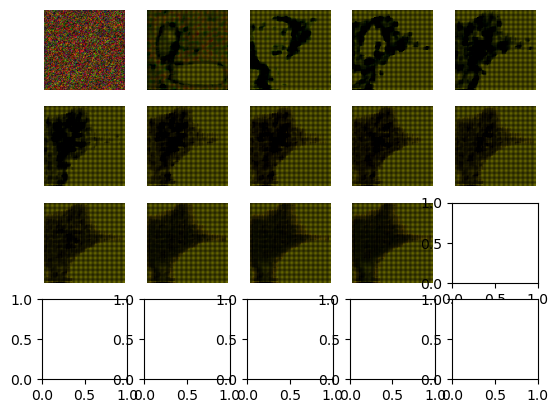

In [13]:
history = overall_histories[0][0]
plot_history(history)

In [153]:
import os
output_dir = f"./output/noise_{NOISE_LEVEL}_down_{DOWN_FACTOR}"
os.makedirs(output_dir, exist_ok = True)

def save_images(histories):
    fig, axes = plt.subplots(LOOPS,len(image_indices))
    for j in range(LOOPS):
        for i in range(len(image_indices)):
            history = overall_histories[j][i]
            output_path = f"{output_dir}/output_{i}.jpg"
            image = history[-1]
            axes[j][i].imshow(image)
            axes[j][i].axis("off")
    
            image = 255 * (image - np.min(image)) / (np.max(image) - np.min(image))
            image = image.astype('uint8')
            image = Image.fromarray(image)
            #image.save(output_path)
    


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

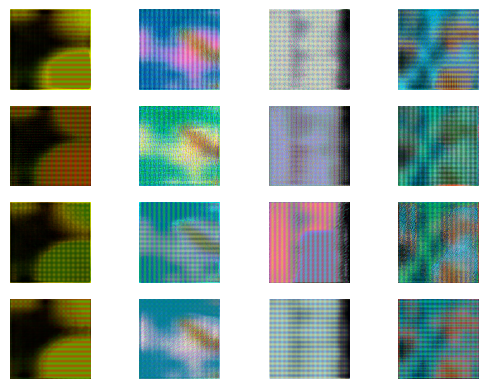

In [154]:
save_images(histories)